## Analysis for glutamate imaging

In [1]:
import matplotlib
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
from scipy.signal import medfilt
from scipy.stats import sem, ranksums, spearmanr
%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set(font_scale=2, style='ticks')

In [2]:
from pathlib import Path
from glob import glob

In [3]:
rootDir = '/mnt/Dali/Takashi/Cezanne/SPIM_newPC/'
folder = '04102019'
fish = 'Fish1-4'
dat_folder = '/nrs/ahrens/Ziqiang/Takashi_DRN_project/SnFRData/'
dir_folder = Path(dat_folder)

In [492]:
from skimage.io import imread

In [493]:
reg_tiff = imread(f'{rootDir}{folder}/{fish}/Registered/registered.tif')

In [495]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import animation
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
from matplotlib.animation import FFMpegFileWriter

In [ ]:
min_raw = np.percentile(reg_tiff, 1)
max_raw = np.percentile(reg_tiff, 99)

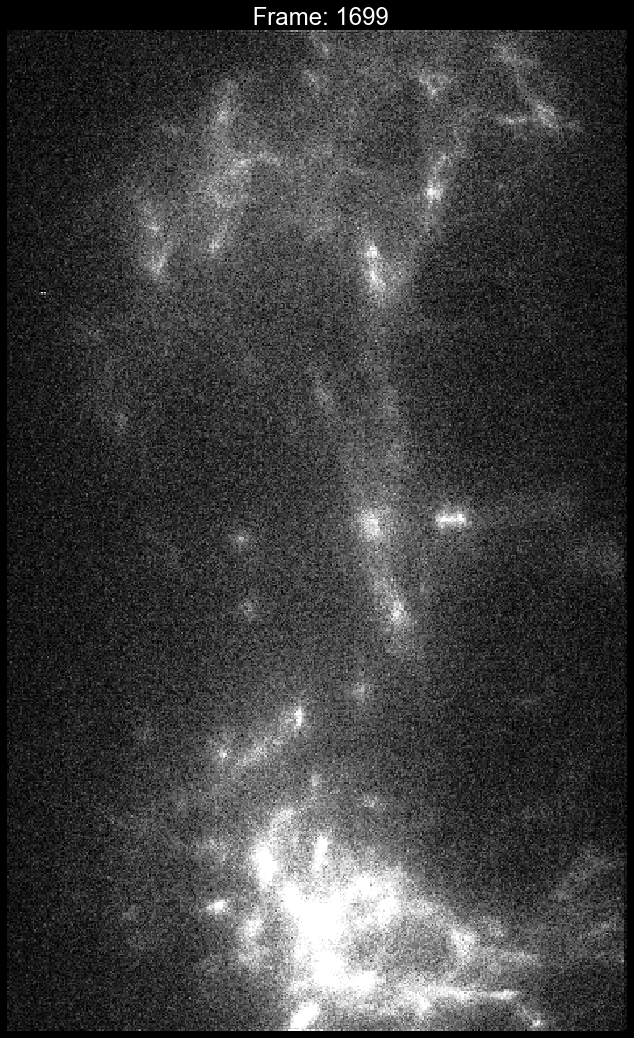

In [505]:
c_list = ['w', 'r', 'b']
plt.style.use('dark_background')
fig, axs = plt.subplots(1, 1, figsize=(9, 9*reg_tiff.shape[1]/reg_tiff.shape[2]))
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
axs.set_axis_off()
axs.set_xticklabels([])
axs.set_yticklabels([])
axs.set(title=" Frame: {}".format(1000))
plt.tight_layout()
imgs = []
imgs.append(axs.imshow(reg_tiff[1000], vmin=min_raw, vmax=max_raw, cmap="Greys_r"))

def update(i):
    axs.set(title=" Frame: {}".format(i+1000))
    imgs[0].set_data(reg_tiff[i+1000]);
    return imgs

num_frames = 700
fps = 25
filename = f'{folder}_{fish}SnFR.mp4'
ani = animation.FuncAnimation(fig, update, frames=num_frames, blit=True);
mywriter = FFMpegFileWriter(fps=fps,codec="h264")
ani.save(filename, writer=mywriter, savefig_kwargs={'facecolor':'black'})

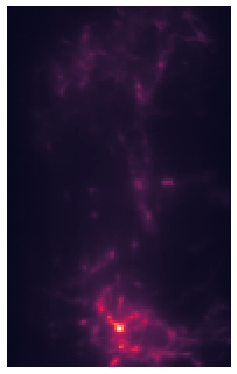

SpearmanrResult(correlation=0.2652916073968705, pvalue=0.11253461250288342)
SpearmanrResult(correlation=0.46181753356771355, pvalue=1.696806854832783e-06)


SpearmanrResult(correlation=0.5862647546580821, pvalue=7.983466725336855e-14)

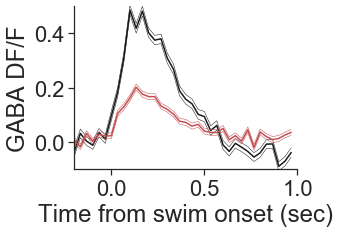

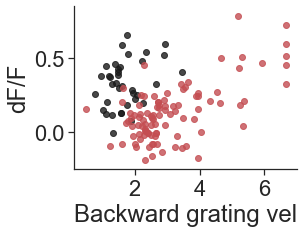

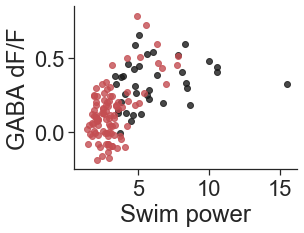

In [181]:
# pamamters
swm_dir = dat_folder+f'{folder}/{fish}/swim/'
img_dir = rootDir+f'{folder}/{fish}/Registered'

frame_rate = 30
t_pre = 20
t_post = 30 # 1 sec according to frame-rate
t_flat = 15
t_valid = 16

# get valid swim data
frame_stimParams = np.load(swm_dir+'frame_stimParams.npy', allow_pickle=True)[()];
frame_swim_tcourse = np.load(swm_dir+"frame_swim_tcourse_series.npy", allow_pickle=True)[()];
rawdata = np.load(swm_dir+"rawdata.npy", allow_pickle=True)[()]
swimdata = np.load(swm_dir+"swimdata.npy", allow_pickle=True)[()]
reclen=len(swimdata['fltCh1'])
frame_tcourse=np.zeros((reclen,))
frame=np.where(np.diff((rawdata['ch3']>3).astype('int'))==1)[0]
for t in range(len(frame)-1):
    frame_tcourse[frame[t]:frame[t+1]]=t
swim_start = frame_tcourse[np.where(swimdata['swimStartT']>0)[0]].astype('int')
swim_end = frame_tcourse[np.where(swimdata['swimEndT']>0)[0]].astype('int')
# collect trial within t-pre, and t-post valid range
swim_end   = swim_end[((swim_start>t_pre) & (swim_start<(frame_swim_tcourse.shape[1]-t_post)))]
swim_start = swim_start[((swim_start>t_pre) & (swim_start<(frame_swim_tcourse.shape[1]-t_post)))]


# get dff data
dFF = np.load(img_dir+'/dFF_sub.npy')[()]
dim = dFF.shape
dFF = dFF.reshape((dim[0],dim[1]*dim[2]),order='F') # dFF reshaped to t x pixels

# remove pixels with low light intensity
ave = np.load(img_dir+'/stack_sub.npy')[()]
ave = ave.mean(axis=0)

plt.figure(figsize=(4, 10))
plt.imshow(ave)
plt.axis('off')
plt.show()

mask_ = ave>150
ave = ave.reshape((1,dim[1]*dim[2]),order='F')
include_pix=np.where(ave>150)[1]
dFF = dFF[:, include_pix]
n_pix = dFF.shape[-1]

swim_list = []
for ntype in range(3):
    _ = swim_start[np.where(frame_stimParams[2,swim_start]==ntype+1)[0]]
    valid = np.diff(_) > t_post
    swim_list.append(_[:-1][valid])

dff_list = []
pswim_list = []
vis_list = []
num_swim_list = []
t_len = int(t_pre+t_post)
for nswim in swim_list:
    num_swim = len(nswim)
    num_swim_list.append(num_swim)
    dff_ = np.zeros((num_swim, t_len, n_pix))
    pswim_ = np.zeros((num_swim, t_len))
    vis_ = np.zeros((num_swim, t_len))
    for ns, s in enumerate(nswim):
        l_swim = frame_swim_tcourse[1,(s-t_pre):(s+t_post)]
        r_swim = frame_swim_tcourse[2,(s-t_pre):(s+t_post)]
        pswim_[ns] = np.sqrt(l_swim**2 + r_swim**2)*100000 # TK: 10000
        dff_[ns] = dFF[(s-t_pre):(s+t_post), :] - dFF[(s-t_flat):s, :].mean(axis=0, keepdims=True)
        vis_[ns] = -frame_stimParams[0,(s-t_pre):(s+t_post)]*10000
    valid_ = np.ones(pswim_.shape[0]).astype('bool')
    valid_ = pswim_[:, -t_valid:].sum(axis=-1)==0
    # valid_ = valid_ & (pswim_.max(axis=-1)<2)
    valid_ = valid_ & (pswim_[:, :t_pre].sum(axis=-1)==0)
    dff_list.append(dff_[valid_])
    pswim_list.append(pswim_[valid_])
    vis_list.append(vis_[valid_])

plt.figure(figsize=(4, 3))
color_list = ['k', 'r', 'b']
for n in range(2):
    ave_ = dff_list[n].mean(axis=0).mean(axis=-1)*100
    sem_ = sem(dff_list[n].mean(axis=0), axis=-1)*100
    plt.plot(np.arange(-t_pre, t_post)/frame_rate, ave_, color_list[n])
    plt.plot(np.arange(-t_pre, t_post)/frame_rate, ave_-sem_, color_list[n], lw=0.5)
    plt.plot(np.arange(-t_pre, t_post)/frame_rate, ave_+sem_, color_list[n], lw=0.5)
sns.despine()
plt.ylabel('GABA DF/F')
plt.xlabel('Time from swim onset (sec)')
plt.xlim([-0.2, 1.0])
plt.ylim([-0.1, 0.5])
plt.yticks(np.arange(0, 0.6, 0.2))
plt.savefig('../Plots/gaba/example_fish_gain_gaba_only.svg')

# fig, ax = plt.subplots(1, 3, figsize=(10, 3))
# ax = ax.flatten()
# color_list = ['k', 'r', 'b']
# for n in range(2):
#     ax[0].plot(np.arange(-t_pre, t_post)/frame_rate, pswim_list[n].mean(axis=0), color_list[n])
#     ax[1].plot(np.arange(-t_pre, t_post)/frame_rate, vis_list[n].mean(axis=0), color_list[n])
#     ax[2].plot(np.arange(-t_pre, t_post)/frame_rate, dff_list[n].mean(axis=0).mean(axis=-1)*100, color_list[n])
#     sns.despine()
# ax[0].set_xlim([-0.2, 1.0])
# ax[1].set_xlim([-0.2, 1.0])
# ax[2].set_xlim([-0.2, 1.0])
# plt.savefig('../Plots/gaba/example_fish.svg')

tmp1 = []
tmp2 = []
plt.figure(figsize=(4, 3))
for n in range(2):
    ave_dff = dff_list[n].mean(axis=-1)*100
    v_ = -(vis_list[n][:, :].min(axis=-1))
    d_ = ave_dff[:, t_pre+0:t_pre+6].mean(axis=-1)
    tmp1.append(v_)
    tmp2.append(d_)
    plt.scatter(v_, d_, c=color_list[n], label=f'Gain #{n}', alpha=0.8)
    print(spearmanr(v_, d_))
plt.xlabel('Backward grating vel')
plt.ylabel('dF/F')
plt.xticks(np.arange(2, 8, 2))
# plt.legend()
sns.despine()
# plt.savefig('../Plots/gaba/example_fish_vel_act.svg')
spearmanr(np.concatenate(tmp1), np.concatenate(tmp2))

tmp1 = []
tmp2 = []
plt.figure(figsize=(4, 3))
for n in range(2):
    ave_dff = dff_list[n].mean(axis=-1)*100
    p_ = pswim_list[n][:, :].max(axis=-1)
    d_ = ave_dff[:, t_pre+0:t_pre+6].mean(axis=-1)
    tmp1.append(p_)
    tmp2.append(d_)
    plt.scatter(np.sqrt(p_), d_, c=color_list[n], label=f'Gain #{n}', alpha=0.8)
plt.xlabel('Swim power')
plt.ylabel('GABA dF/F')
# plt.xlim([0, 80])
# plt.legend()
sns.despine()
# plt.yticks(np.arange(0, 1.2, 0.4))
# plt.xticks(np.arange(0, 120, 40))
# plt.savefig('../Plots/gaba/example_fish_power_act.svg')
spearmanr(np.concatenate(tmp1), np.concatenate(tmp2))

SpearmanrResult(correlation=0.5862647546580821, pvalue=7.983466725336855e-14)

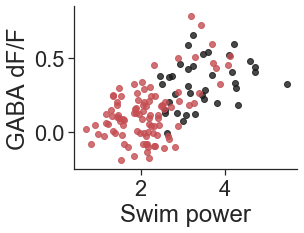

In [182]:
tmp1 = []
tmp2 = []
plt.figure(figsize=(4, 3))
for n in range(2):
    ave_dff = dff_list[n].mean(axis=-1)*100
    p_ = pswim_list[n][:, :].max(axis=-1)
    d_ = ave_dff[:, t_pre+0:t_pre+6].mean(axis=-1)
    tmp1.append(p_)
    tmp2.append(d_)
    plt.scatter(np.log(p_), d_, c=color_list[n], label=f'Gain #{n}', alpha=0.8)
plt.xlabel('Swim power')
plt.ylabel('GABA dF/F')
# plt.xlim([0, 80])
# plt.legend()
sns.despine()
# plt.yticks(np.arange(0, 1.2, 0.4))
# plt.xticks(np.arange(0, 120, 40))
# plt.savefig('../Plots/gaba/example_fish_power_act.svg')
spearmanr(np.concatenate(tmp1), np.concatenate(tmp2))

In [8]:
from scipy.ndimage import percentile_filter

In [387]:
# get dff data
dFF = np.load(img_dir+'/dFF_sub.npy')[()]
dim = dFF.shape
dFF = dFF.reshape((dim[0],dim[1]*dim[2]),order='F') # dFF reshaped to t x pixels
# remove pixels with low light intensity
ave = np.load(img_dir+'/stack_sub.npy')[()]
ave = ave.mean(axis=0)
mask_ = ave>150
ave = ave.reshape((1,dim[1]*dim[2]),order='F')
include_pix=np.where(ave>150)[1]
# dFF = dFF[:, include_pix]

In [388]:
dFF.shape

(18550, 14880)

In [317]:
dFF_fit = np.mean(dFF, axis=1)-1
dFF_bl = percentile_filter(dFF_fit, 10, size=(600))

In [318]:
frame_stimParams = np.load(swm_dir+'frame_stimParams.npy', allow_pickle=True)[()];
frame_swim_tcourse = np.load(swm_dir+"frame_swim_tcourse_series.npy", allow_pickle=True)[()];
swim_power = frame_swim_tcourse[0]*100000
visu = frame_stimParams[0]*10
visu = visu.clip(0, None)
epoch = frame_stimParams[2]

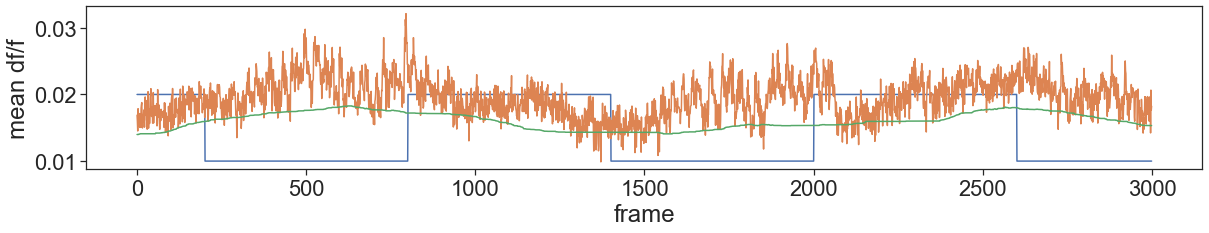

In [321]:
plt.figure(figsize=(20, 3))
# plt.plot(swim_power)
plt.plot(epoch[1000:4000]*0.01)
plt.plot(dFF_fit[1000:4000])
plt.plot(dFF_bl[1000:4000])
plt.xlabel('frame')
plt.ylabel('mean df/f')
plt.show()

In [322]:
dff_dir = dat_folder+f'{folder}/{fish}/Data/'

In [324]:
_ = np.load(dff_dir+'components.npz');
A_ = _['A_']
C_ = _['C_']
dFF_ = C_.T

In [331]:
A_.shape

(14880, 35)

In [325]:
dFF_.shape

(18550, 35)

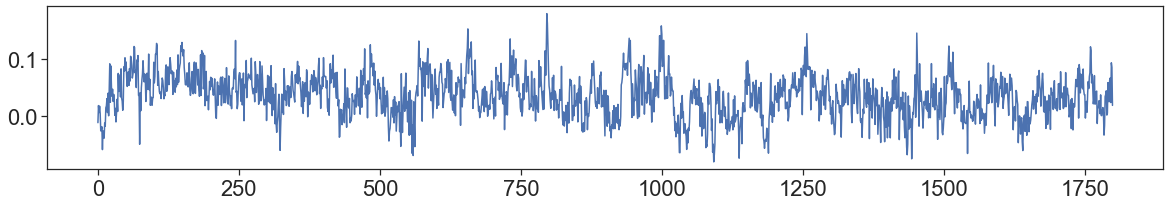

In [490]:
n_c = 34
plt.figure(figsize=(20, 3))
plt.plot((dFF_-np.percentile(dFF_, 20, axis=0))[:, n_c][1000:2800])
plt.show()

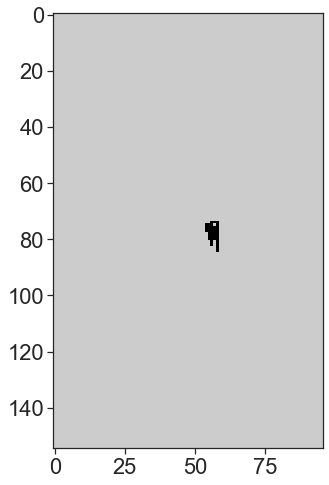

In [491]:
A_c = A_[:, n_c]
# A_comp[A_.sum(axis=-1)>0] = np.argmax(A_c[A_.sum(axis=-1)>0, :], axis=-1)
# A_mat =A_comp.reshape(dim[2], dim[1]).T
A_mat = (A_c>0).reshape(dim[2], dim[1]).T

plt.figure(figsize=(8, 8))
# A_mat[A_mat>0] = A_mat[A_mat>0]+1
plt.imshow(A_mat, cmap=plt.cm.nipy_spectral_r)

In [402]:
A_.shape

(14880, 35)

In [389]:
dFF_Comp = []
for n in range(A_.shape[-1]):
    dFF_Comp.append(dFF[:, A_[:, n]>0].mean(axis=-1))

In [390]:
dFF_Comp = np.array(dFF_Comp)

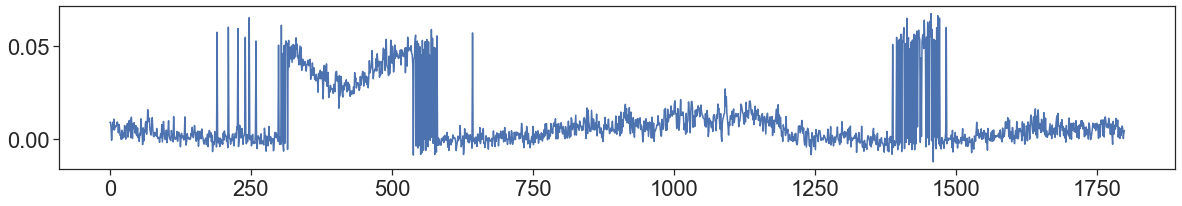

In [416]:
plt.figure(figsize=(20, 3))
plt.plot((dFF_Comp-np.percentile(dFF_Comp, 20, axis=0))[3][1000:2800])
plt.show()

In [287]:
dFF_fit -= dFF_bl

In [365]:
dFF_fit = (dFF_-np.percentile(dFF_, 20, axis=0))[:, 20]

In [366]:
t_s = 0.3
d_s = 1.7
winsize=300
fr=30
t_v = 0.3
d_v = 0.5
w_v = 0.0

In [367]:
ca_pred = swim_vis_kernel(t_s, d_s, t_v, d_v, w_v, swim_power, visu, winsize=winsize, fr=fr)

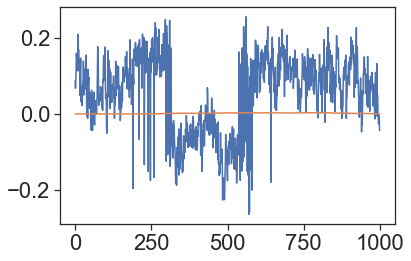

In [368]:
plt.plot(dFF_fit[1000:2000])
plt.plot(ca_pred[1000:2000]/100000)
# plt.plot(swim_power[1000:2000])

In [369]:
import scipy.optimize as sopt

In [370]:
def swim_vis_kernel(t_s, d_s, t_v, d_v, w_v, swim_list, vis_list, winsize=300, fr=30):
    t_ = np.arange(winsize)/30
    k_s = (1 - np.exp(-t_/t_s))* np.exp(-t_/d_s)
    k_v = w_v * (1 - np.exp(-t_/t_v))* np.exp(-t_/d_v)
    return (np.convolve(swim_list, k_s, 'full') + np.convolve(vis_list, k_v, 'full'))

In [371]:
def ca_to_f(ca_t, fmax, ca0, k):
    # return fmax/(1+np.exp(-(ca_t-ca0)*k))
    return fmax * ca_t

In [372]:
def swim_vis_model(swim_list, vis_list, fmax, ca0, k, t_s, d_s, t_v, d_v, w_v):
    ca_pred = swim_vis_kernel(t_s, d_s, t_v, d_v, w_v, swim_list, vis_list)
    return ca_to_f(ca_pred, fmax, ca0, k)

In [373]:
def loss_func(param, dff=dFF_fit, swim_list=np.log(swim_power+1e-10).clip(0, None), vis_list=visu):
    fmax, ca0, k, t_s, d_s, = param
    t_v, d_v, w_v = (0.05, 0.05, 0.0)
    t_len = min(len(dff), len(swim_list)) - 500
    dff_pred = swim_vis_model(swim_list, vis_list, fmax, ca0, k, t_s, d_s, t_v, d_v, w_v)
    return ((dff_pred[1000:t_len]-dff[1000:t_len])**2).sum()

In [374]:
fmax = dFF_fit.max()
ca0 = dFF_fit.max()*0.4
k = 100
ts = 0.05
ds = 1.7
param = (fmax, ca0, k, ts, ds)
# res = sopt.minimize(loss_func, param, method='BFGS', options={'disp': True})
res = sopt.minimize(loss_func, param, method='Nelder-Mead', options={'disp': True})

Optimization terminated successfully.
         Current function value: 148.169918
         Iterations: 243
         Function evaluations: 434


In [375]:
res.x

array([8.03784281e-04, 2.71701062e-01, 1.20587537e+02, 7.63794378e-08,
       3.19355215e+00])

In [376]:
fmax, ca0, k, t_s, d_s = res.x
t_v, d_v, w_v = (0.05, 0.05, 0.0)
t_len = min(len(dFF_fit), len(swim_list)) - 500
dff_pred = swim_vis_model(np.log(swim_power+1e-10).clip(0, None), visu, fmax, ca0, k, t_s, d_s, t_v, d_v, w_v)

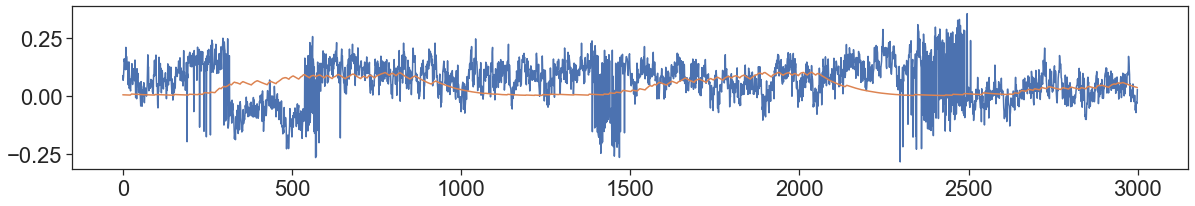

In [377]:
plt.figure(figsize=(20, 3))
plt.plot(dFF_fit[1000:4000])
plt.plot(dff_pred[1000:4000])
# plt.plot(epoch[3000:4000]/1000)
# plt.plot(np.log(swim_power+1e-10).clip(0, None)[1000:4000]/1000)
plt.show()